<a href="https://colab.research.google.com/github/vthuhien/Fraud_Data/blob/main/Orders_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read Data Source

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/pandas/ex/Orders_Data/Fraud_Data.csv', parse_dates= ['signup_time','purchase_time']) # parse_date uses to convert 2 col to format datetime

df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [ ]:
df.shape

(151112, 11)

In [ ]:
df.dtypes

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
is_fraud                   int64
dtype: object

In [ ]:
df.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
is_fraud          0
dtype: int64

In [ ]:
df.nunique()

user_id           151112
signup_time       151112
purchase_time     150679
purchase_value       122
device_id         137956
source                 3
browser                5
sex                    2
age                   58
ip_address        143511
is_fraud               2
dtype: int64

In [ ]:
dtype = {
    'upper_bound_ip_address': 'float64'
}
df_ip = pd.read_csv('/content/drive/My Drive/Colab Notebooks/pandas/ex/Orders_Data/IpAddress_to_Country.csv',dtype =dtype)
df_ip = df_ip.sort_values('lower_bound_ip_address')
df_ip

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,1.677747e+07,Australia
1,1.677747e+07,1.677773e+07,China
2,1.677773e+07,1.677824e+07,China
3,1.677824e+07,1.677926e+07,Australia
4,1.677926e+07,1.678131e+07,China
...,...,...,...
138841,3.758092e+09,3.758093e+09,Hong Kong
138842,3.758093e+09,3.758094e+09,India
138843,3.758095e+09,3.758096e+09,China
138844,3.758096e+09,3.758096e+09,Singapore


In [ ]:
df_ip.shape

(138846, 3)

In [ ]:
df_ip.dtypes

lower_bound_ip_address    float64
upper_bound_ip_address    float64
country                    object
dtype: object

In [ ]:
df_ip.isna().sum()

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

### Feature Engineering
Before analyzing, we start to merge 2 files data to one dataframe. This makes statistic more easily and clearly

In [ ]:

df = df.sort_values(by=['ip_address'])
df_all = pd.merge_asof(df,df_ip,left_on='ip_address',right_on='lower_bound_ip_address')
# df_all = pd.concat([df,df_ip], ignore_index = True)

df_all.tail(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,lower_bound_ip_address,upper_bound_ip_address,country
151107,361167,2015-04-16 05:00:09,2015-07-31 21:21:47,39,DDZWCUYTHKALI,Direct,FireFox,F,36,4.294674e+09,0,3.758096e+09,3.758096e+09,Australia
151108,62422,2015-08-08 06:25:41,2015-08-28 04:01:06,62,YJLXUZPSHUOOS,SEO,IE,M,22,4.294715e+09,0,3.758096e+09,3.758096e+09,Australia
151109,260255,2015-02-18 21:07:18,2015-04-25 06:20:38,17,LPIWPXJCMYJOT,SEO,FireFox,M,19,4.294720e+09,0,3.758096e+09,3.758096e+09,Australia
151110,172984,2015-08-15 15:40:46,2015-10-30 09:47:39,9,TSDCMHPWAUZAR,Ads,IE,F,35,4.294822e+09,0,3.758096e+09,3.758096e+09,Australia
151111,168001,2015-03-03 11:27:19,2015-05-05 10:32:46,39,JLVKRXCKCWNLW,Ads,FireFox,F,41,4.294850e+09,0,3.758096e+09,3.758096e+09,Australia


As shown, present, this data has some columns that need to be dealt with. Idea in here is :
* First, get values ip_address range from upper_bound and lower_bound and then name the result as `is_between`
* Check the column `is_between`. If it is false, we will change the values of `country` to 'unknown' but if it true, we will keep them
* After that, we drop all the values of 'unknow' and keep the other values in `country` column.

In [ ]:
df_all['is_between'] = df_all['ip_address'].between(df_all['lower_bound_ip_address'],
                                                    df_all['upper_bound_ip_address'])
df_all['country'] = df_all[['country','is_between']].apply(lambda x : x[0] if x[1] else 'Unknown', axis = 1)
df_all

<ipython-input-16-47541c24e62c>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_all['country'] = df_all[['country','is_between']].apply(lambda x : x[0] if x[1] else 'Unknown', axis = 1)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,lower_bound_ip_address,upper_bound_ip_address,country,is_between
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,5.209350e+04,0,NaN,NaN,Unknown,False
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,9.344714e+04,0,NaN,NaN,Unknown,False
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,1.058185e+05,0,NaN,NaN,Unknown,False
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,1.175667e+05,0,NaN,NaN,Unknown,False
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,1.314238e+05,0,NaN,NaN,Unknown,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,361167,2015-04-16 05:00:09,2015-07-31 21:21:47,39,DDZWCUYTHKALI,Direct,FireFox,F,36,4.294674e+09,0,3.758096e+09,3.758096e+09,Unknown,False
151108,62422,2015-08-08 06:25:41,2015-08-28 04:01:06,62,YJLXUZPSHUOOS,SEO,IE,M,22,4.294715e+09,0,3.758096e+09,3.758096e+09,Unknown,False
151109,260255,2015-02-18 21:07:18,2015-04-25 06:20:38,17,LPIWPXJCMYJOT,SEO,FireFox,M,19,4.294720e+09,0,3.758096e+09,3.758096e+09,Unknown,False
151110,172984,2015-08-15 15:40:46,2015-10-30 09:47:39,9,TSDCMHPWAUZAR,Ads,IE,F,35,4.294822e+09,0,3.758096e+09,3.758096e+09,Unknown,False


In [ ]:
df_all = df_all.drop(columns = ['lower_bound_ip_address','upper_bound_ip_address','is_between'])
df_all = df_all.sort_values('signup_time', ignore_index = False)
print((df_all['country']=='Unknown').sum())

21966


In [ ]:
df_all

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,country
69929,286057,2015-01-01 00:00:42,2015-03-25 11:33:06,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,0,Korea Republic of
69934,309557,2015-01-01 00:00:43,2015-01-01 00:00:44,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of
69931,124539,2015-01-01 00:00:44,2015-01-01 00:00:45,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of
69933,161246,2015-01-01 00:00:45,2015-01-01 00:00:46,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of
69930,356414,2015-01-01 00:00:46,2015-01-01 00:00:47,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of
...,...,...,...,...,...,...,...,...,...,...,...,...
65493,278100,2015-08-18 04:29:35,2015-12-01 12:37:41,16,RYXSITDFDKNTU,SEO,FireFox,M,45,1.879590e+09,0,China
12872,8209,2015-08-18 04:31:11,2015-09-28 14:25:10,34,PSWNKGEEZGYBG,SEO,Chrome,M,30,3.560499e+08,1,United States
3186,386025,2015-08-18 04:31:58,2015-12-15 08:30:14,22,KPQQUAPBZTWSG,Direct,Chrome,F,35,8.723900e+07,0,France
43446,368886,2015-08-18 04:37:34,2015-12-07 00:17:59,33,FCPXNSONDFFJH,Direct,IE,M,28,1.240184e+09,0,United States


### Eploratory Data Analysis
Summary statistics for some numerical and categorical columns:
1. Numerical:
  - purchase_value
  - age
2. Categorical
  - source
  - browser
  - sex
  - country
  - is_fraud

In [ ]:
df_all[['purchase_value','age']].describe()

,purchase_value,age
count,151112.000000,151112.000000
mean,36.935372,33.140704
std,18.322762,8.617733
min,9.000000,18.000000
25%,22.000000,27.000000
50%,35.000000,33.000000
75%,49.000000,39.000000
max,154.000000,76.000000


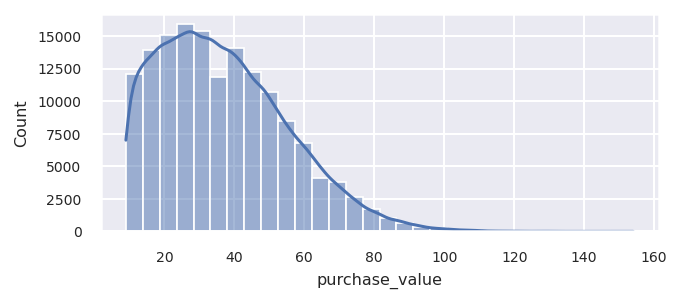

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2))
sns.histplot(data=df_all, x='purchase_value', kde=True, bins=30, ax=ax);

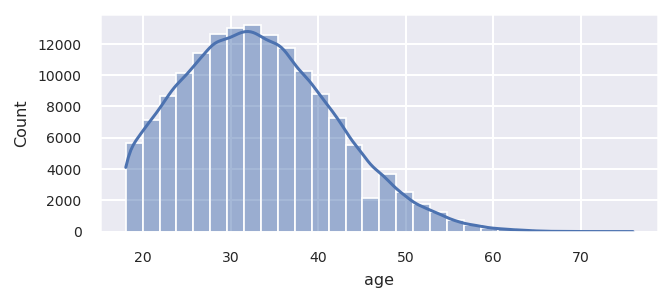

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2))
sns.histplot(data=df_all, x='age', kde=True, bins=30, ax=ax);

In [ ]:
# Convert to boolean
df_all['is_fraud'] = df_all['is_fraud'].astype(bool)

In [ ]:
categorical_types = ['object','bool']
categorical_cols = df_all.select_dtypes(categorical_types).columns.tolist()
print(categorical_cols)
del categorical_cols[0]

['device_id', 'source', 'browser', 'sex', 'is_fraud', 'country']


In [ ]:
for col in categorical_cols:
  print("="*50)
  print(f'{" "*20}{col}{" "*20}')
  print("="*50)
  print(df_all[col].value_counts(normalize=True))
  print('\n')

                    source                    
SEO       0.401126
Ads       0.396269
Direct    0.202605
Name: source, dtype: float64


                    browser                    
Chrome     0.406533
IE         0.243045
Safari     0.163237
FireFox    0.162859
Opera      0.024326
Name: browser, dtype: float64


                    sex                    
M    0.584288
F    0.415712
Name: sex, dtype: float64


                    is_fraud                    
False    0.906354
True     0.093646
Name: is_fraud, dtype: float64


                    country                    
United States                     0.384146
Unknown                           0.145362
China                             0.079663
Japan                             0.048348
United Kingdom                    0.029713
                                    ...   
Gambia                            0.000007
British Indian Ocean Territory    0.000007
Madagascar                        0.000007
Yemen                           

In [ ]:
#Find percent of countries that appear less than 50 times.
(df_all['country'].value_counts()<50).mean()

0.5714285714285714

#### Univariate exploration

In [ ]:
df_all.groupby('source').agg(count=('is_fraud', 'size'), perc_fraud=('is_fraud', 'mean'))

,count,perc_fraud
source,,
Ads,59881,0.092066
Direct,30616,0.105370
SEO,60615,0.089285


In [ ]:
df_all.groupby('browser').agg(count=('is_fraud', 'size'), perc_fraud=('is_fraud', 'mean'))

,count,perc_fraud
browser,,
Chrome,61432,0.098792
FireFox,24610,0.095165
IE,36727,0.086775
Opera,3676,0.089227
Safari,24667,0.090201


In [ ]:
df_all.groupby('sex').agg(count=('is_fraud', 'size'), perc_fraud=('is_fraud', 'mean'))

,count,perc_fraud
sex,,
F,62819,0.091007
M,88293,0.095523


In [ ]:
# Look at the highest and lowest fraud by countries with more than 50 transactions.
df_country = df_all.groupby('country').agg(count=('is_fraud', 'size'), perc_fraud=('is_fraud', 'mean'))
df_country.query('count > 50').nlargest(15, 'perc_fraud')

,count,perc_fraud
country,,
Luxembourg,72,0.388889
Ecuador,106,0.264151
Tunisia,118,0.262712
Peru,119,0.260504
Bolivia,53,0.245283
Kuwait,90,0.233333
Ireland,240,0.229167
New Zealand,278,0.223022
Lithuania,95,0.189474


In [ ]:
df_country.query('count > 50').nsmallest(15, 'perc_fraud')

,count,perc_fraud
country,,
Bulgaria,166,0.012048
Serbia,69,0.014493
Slovenia,87,0.022989
Belarus,72,0.027778
Morocco,158,0.031646
Dominican Republic,51,0.039216
Pakistan,186,0.043011
Portugal,229,0.043668
Israel,272,0.044118


In [ ]:
# Looking at the top 15 larges countries
df_country.nlargest(15, 'count')

,count,perc_fraud
country,,
United States,58049,0.095626
Unknown,21966,0.085723
China,12038,0.086642
Japan,7306,0.097865
United Kingdom,4490,0.106236
Korea Republic of,4162,0.091302
Germany,3646,0.071860
France,3161,0.094907
Canada,2975,0.116975


In [ ]:
df_all.corr()['is_fraud']

NameError: name 'df_all' is not defined

In [ ]:
# Apply bin to purchase value to see any signals of fraud
bins = pd.cut(df_all['purchase_value'], bins=list(range(5, 105, 10)) + [200])
df_temp = df_all.groupby(bins).agg(count=('is_fraud', 'size'), perc_fraud=('is_fraud', 'mean'))
df_temp['perc_fraud'] = df_temp['perc_fraud'].round(3) * 100
df_temp

,count,perc_fraud
purchase_value,,
"(5, 15]",17542,9.2
"(15, 25]",29738,9.9
"(25, 35]",31096,8.9
"(35, 45]",27411,9.0
"(45, 55]",20630,9.6
"(55, 65]",13092,10.4
"(65, 75]",6905,8.8
"(75, 85]",2965,8.4
"(85, 95]",1206,12.7


In [ ]:
bins = pd.cut(df_all['age'], bins=list(range(15, 70, 5)) + [100])
df_temp = df_all.groupby(bins).agg(count=('is_fraud', 'size'), perc_fraud=('is_fraud', 'mean'))
df_temp['perc_fraud'] = df_temp['perc_fraud'].round(3) * 100
df_temp

,count,perc_fraud
age,,
"(15, 20]",9035,9.1
"(20, 25]",22522,9.0
"(25, 30]",30433,8.9
"(30, 35]",32389,9.7
"(35, 40]",26611,10.0
"(40, 45]",17008,9.3
"(45, 50]",8375,8.9
"(50, 55]",3394,10.0
"(55, 60]",1043,9.1


#### Multivariate exploration
We can look at different combinations of the categorical variables to see if there is any signal

In [ ]:
def fraud_group(df, cols, min_count=50, n=10):
    df = df.groupby(cols) \
           .agg(count=('is_fraud', 'size'),
                perc_fraud=('is_fraud', 'mean'),
                avg_price=('purchase_value', 'mean'))
    df['perc_fraud'] = df['perc_fraud'].round(3) * 100
    return df.query('count > @min_count').nlargest(n, 'perc_fraud')

In [ ]:
fraud_group(df_all, ['browser', 'source', 'sex'])

,,,count,perc_fraud,avg_price
browser,source,sex,,,
Opera,Direct,M,439,12.8,37.879271
Chrome,Direct,M,7323,12.2,36.942510
IE,Direct,M,4382,11.5,37.425377
Chrome,Direct,F,5403,11.2,36.910605
FireFox,SEO,F,4135,10.6,36.177751
Safari,SEO,F,4268,10.2,37.293580
Chrome,Ads,F,10075,10.0,36.972605
Safari,Ads,M,5767,10.0,36.609676
FireFox,Ads,F,4116,9.9,37.674927


In [ ]:
# Adding in country, there are some combinations that have much higher fraud, though the overall counts are low.
fraud_group(df_all, ['country', 'browser', 'source', 'sex'])

,,,,count,perc_fraud,avg_price
country,browser,source,sex,,,
India,FireFox,SEO,F,51,43.1,24.274510
Denmark,Chrome,SEO,M,73,41.1,32.041096
Egypt,Chrome,Ads,M,56,39.3,46.928571
Canada,Safari,SEO,M,153,35.3,34.189542
Spain,FireFox,SEO,M,56,33.9,39.839286
Italy,FireFox,Direct,M,55,30.9,43.709091
Sweden,Chrome,Ads,F,86,29.1,34.616279
Taiwan; Republic of China (ROC),FireFox,Ads,M,58,27.6,42.241379
Australia,FireFox,SEO,F,70,27.1,41.785714


In [ ]:
#We can use the bins for age and purchase value as well.
bins = pd.cut(df_all['age'], bins=list(range(15, 70, 5)) + [100])
fraud_group(df_all, ['browser', 'source', bins])

count  perc_fraud  avg_price
browser source age                                   
Opera   Direct (15, 20]     66        37.9  36.636364
FireFox SEO    (55, 60]     92        32.6  34.826087
Chrome  Ads    (60, 65]     56        23.2  38.732143
Safari  Ads    (50, 55]    247        22.3  39.000000
Opera   SEO    (20, 25]    253        17.0  36.988142
FireFox SEO    (50, 55]    252        16.3  36.869048
Opera   Ads    (20, 25]    218        16.1  35.096330
        Direct (30, 35]    173        15.6  38.080925
FireFox SEO    (45, 50]    581        15.1  36.975904
Chrome  Direct (55, 60]     83        14.5  43.542169

##### Explore signup and purchase time

In [ ]:
# Seconds until purchase
secs_to_purchase = (df_all['purchase_time'] - df_all['signup_time']).dt.total_seconds()
secs_to_purchase.head(3)

69929    7212744.0
69934          1.0
69931          1.0
dtype: float64

In [ ]:
# Interestingly, the first few rows all had purchases after one second and all were fraudulent. Let's select all purchases that happened in one second.
filt = secs_to_purchase == 1
df_all.loc[filt, 'is_fraud'].agg(['mean', 'size'])
# Remarkably, every single transaction that took place in 1 second was marked as fraud.

mean       1.0
size    7600.0
Name: is_fraud, dtype: float64

In [ ]:
# Separating out 1 second transactions
df_one_second = df_all[filt].reset_index(drop=True)
df_remaining = df_all[~filt].reset_index(drop=True)

In [ ]:
# Metadata for new datasets
print(df_one_second.shape)
print(df_remaining.shape)

(7600, 12)
(143512, 12)


In [ ]:
# Does country effect fraud percentage
print((df_remaining['country'] == "Unknown").mean() * 100)
print((df_one_second['country'] == "Unknown").mean() * 100)

14.641981158370033
12.539473684210526


##### Repeating IP Addresses

In [ ]:
df_one_second['ip_address'].value_counts().head()

3.874758e+09    19
2.050964e+09    19
1.502818e+09    19
5.760609e+08    19
1.800550e+09    18
Name: ip_address, dtype: int64

In [ ]:
df_remaining['ip_address'].value_counts().head()

4.269199e+09    2
9.267786e+08    1
2.853442e+09    1
2.341931e+09    1
4.213306e+09    1
Name: ip_address, dtype: int64

##### Device ID
We now turn our attention to device_id. From the number of unique values, we know there are some that repeat. Let's look at those first.

In [ ]:
df_remaining['device_id'].value_counts()[lambda x: x > 1].head()

YLDDOCJIVHEJV    4
QHNJXBTHZFQPT    3
CIWZEIWVKCTDZ    3
CGLAEGEJMRFXY    3
XOCYJLEAYQFSB    3
Name: device_id, dtype: int64

In [ ]:
# The repeated device IDs are assigned to a variable
repeat_device_id = df_all['device_id'].value_counts()[lambda x: x > 1].index
repeat_device_id[:10]

Index(['ZUSVMDEZRBDTX', 'NGQCKIADMZORL', 'CQTUVBYIWWWBC', 'ITUMJCKWEYNDD',
       'KIPFSCNUGOLDP', 'EQYVNEGOFLAWK', 'SDJQRPKXQFBED', 'IGKYVZDBEGALB',
       'EGLGSEGYPMMAM', 'BWSMVSLCJXMCM'],
      dtype='object')

In [ ]:
# All transactions for these repeats are placed in their own DataFrame.
df_repeat_device = df_remaining.query('device_id in @repeat_device_id') \
                               .sort_values('device_id', ignore_index=True)
df_repeat_device.head(4)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,country
0,209275,2015-01-01 04:25:21,2015-01-28 10:39:35,57,AAAXXOZJRZRAO,Ads,FireFox,F,36,1.377849e+09,False,United Kingdom
1,226990,2015-06-18 08:32:44,2015-10-05 08:05:50,14,AAEWGRKQJJMVI,Ads,IE,F,41,3.617303e+09,False,United States
2,1468,2015-07-24 19:29:24,2015-09-04 03:14:11,63,AAEWGRKQJJMVI,Direct,Chrome,F,33,5.604791e+08,True,United States
3,239598,2015-01-18 11:00:53,2015-01-24 11:14:56,41,AAFBODGQYEMVK,Direct,IE,F,30,7.107753e+08,False,China


In [ ]:
df_repeat_device.shape

(11731, 12)

Higher fraud for repeated device ID

In [ ]:
df_repeat_device['is_fraud'].mean()

0.21660557497229563

In [ ]:
#A feature is created to indicate the number of the transaction for the given device ID.
df_repeat_device['device_ct'] = df_repeat_device.groupby('device_id').cumcount() + 1
df_repeat_device[['device_id', 'device_ct', 'is_fraud']].head(6)

,device_id,device_ct,is_fraud
0,AAAXXOZJRZRAO,1,False
1,AAEWGRKQJJMVI,1,False
2,AAEWGRKQJJMVI,2,True
3,AAFBODGQYEMVK,1,False
4,AAFBODGQYEMVK,2,False
5,AAIGAICKBXPSW,1,False


In [ ]:
# This enables us to test whether the first, second transaction has more probability of fraud.
# Below, we see that the second transaction from the same device ID has similar fraud as the first
df_repeat_device.groupby('device_ct')['is_fraud'].agg(['size', 'mean'])

,size,mean
device_ct,,
1,6175,0.208097
2,5465,0.225984
3,90,0.233333
4,1,0.000000


### Simplest model without machine learning
I like to formulate models without machine learning that can act as a baseline. There appear to be only two significant signals thus far:

- One second until purchase
- Repeated device ID

####Expected value of flagged fraud
Repeated device IDs showed to be 22% fraudulent, much higher than the 4.6% baseline. But, we must take into account the cost of an incorrectly flagged transaction (8 dollars). Even knowing that a device ID repeats, we will be wrong 78% of the time. In order to break even, the purchase price multiplied by the probability of fraud must be greater than 8 times the probability of not fraud.

In [ ]:
# We solve for the minimum purchase price.
INCORRECT_FRAUD_COST = 8
def calc_min_price(p):
    min_purchase_price = (1 - p) * INCORRECT_FRAUD_COST / p
    return min_purchase_price

p = df_repeat_device['is_fraud'].mean()
calc_min_price(p)

28.933490751672572

In [ ]:
def calc_income(df, min_price):
    df = df[['purchase_value', 'is_fraud']].copy()
    df['flag'] = 0
    df['cost'] = 0
    df['saved'] = 0
    df['revenue'] = 0
    is_flag = df['purchase_value'] >= min_price
    is_fraud = df['is_fraud'] == 1
    df.loc[is_flag, 'flag'] = 1
    false_pos = is_flag & ~is_fraud
    false_neg = ~is_flag & is_fraud
    true_pos = is_flag & is_fraud
    df.loc[false_pos, 'cost'] = -INCORRECT_FRAUD_COST
    df.loc[false_neg, 'cost'] = -df['purchase_value']
    df.loc[true_pos, 'saved'] = df['purchase_value']
    df.loc[df['is_fraud'] == 0, 'revenue'] = df['purchase_value']
    df['income'] = df['revenue'] + df['cost']
    return df

In [ ]:
def plot_threshold(df, col, title):
    s = pd.Series({i: calc_income(df, i)[col].sum() for i in range(9, 100)})
    ax = s.plot(figsize=(5, 2.5))
    ax.set_ylabel('Cost')
    ax.set_xlabel('Minimum Price Threshold')
    ax.set_title(title);

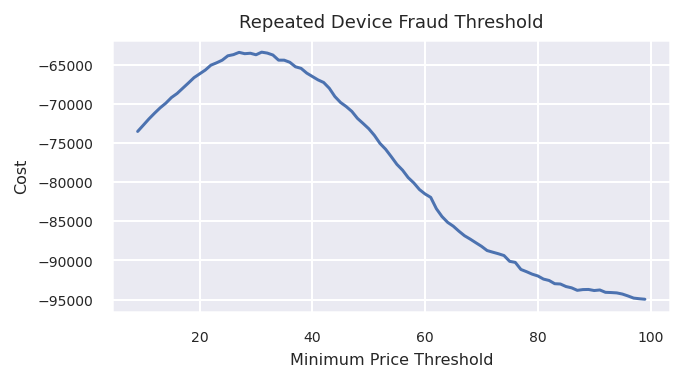

In [ ]:
plot_threshold(df_repeat_device, 'cost', 'Repeated Device Fraud Threshold')